# **Introduction**

This analysis aims to provide actionable insights into improving public transportation systems
by combining a countrywide perspective with a detailed study of New York City's transit systems.
We focus on two key areas:
1. **Statewide Transit Trends** (NTD Dataset): Identify characteristics of successful transit systems.
2. **CitiBike Integration**: Assess CitiBike's role in complementing public transit in NYC.

---

## **Statewide Analysis: Introduction to the NTD Dataset**
The National Transit Database (NTD) dataset provides comprehensive information about transit agencies across the United States. The dataset includes details such as funding sources, operational expenses, and transit modes. Key attributes include:

- **Agency Information**: `agency`, `city`, `state`, and `ntd_id` to identify transit providers.
- **Transit Characteristics**: `mode`, `mode_name`, and `tos` (type of service) describe the mode of transit and operational characteristics.
- **Funding**: Variables like `general_fund`, `income_tax`, `sales_tax`, and `property_tax` provide insights into the financial sources supporting transit operations.
- **Performance Metrics**: `total_funding`, `total_expenses`, and `profit` indicate the financial viability of transit systems.

---

### **Variables for Prediction**
Based on the goals of the project, the most important variables for analysis include:

1. **Funding Sources and Amounts**: 
   - Variables such as `general_fund`, `sales_tax`, `tolls`, and `other_tax` help determine the reliance on various revenue streams.
   - These factors are critical for predicting the financial stability and investment capacity of transit agencies.

2. **Transit Mode and Type of Service**:
   - Variables like `mode` (e.g., Bus, Demand Response, Vanpool) and `tos` (e.g., Directly Operated or Purchased Transportation) reveal the service type and operational characteristics.
   - These are important for analyzing efficiency and service performance.

3. **Operational Metrics**:
   - Metrics such as `vehicle_operations`, `vehicle_maintenance`, and `facility_maintenance` highlight operational costs, which are key to understanding cost-efficiency.
   - Variables like `agency_voms` (vehicles operated at maximum service) and `mode_voms` provide insights into capacity utilization.

4. **Profitability**:
   - `profit` is the ultimate target variable for agencies seeking to optimize resources and enhance financial performance.
   - It is computed as the difference between `total_funding` and `total_expenses`.

---

In [169]:
# --- Libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from pprint import pprint
from plotnine import *

In [170]:
ntd_data = pd.read_csv("Data/Merged-NTA.csv")

# Display one row of the data
one_row = ntd_data.iloc[3]
one_row_df = pd.DataFrame(one_row).transpose()

# Explain the selected row
row_explanation = f"""
This row represents data for the agency {one_row['agency']} located in {one_row['city']}, {one_row['state']}.
Key details include:
- Report Year: {one_row['report_year']}
- Total Funding: {one_row['total_funding']}
- Total Expenses: {one_row['total_expenses']}
- Profit: {one_row['profit']}
- Transit Mode: {one_row['mode_name']} ({one_row['mode']})
- Vehicles Operated at Maximum Service: {one_row['mode_voms']}
"""
print("Sample Data Row:")
one_row_df

Sample Data Row:


,agency,city,state,ntd_id,organization_type,reporter_type,report_year,uace_code,uza_name,primary_uza_population,...,tos,mode_voms,vehicle_operations,vehicle_maintenance,facility_maintenance,general_administration,reduced_reporter_expenses,total_expenses,purchased_transportation_reported_separately,profit
3,"Broome County, dba: BC Transit",Binghamton,NY,20003,"City, County or Local Government Unit or Depar...",Full Reporter,2023,7732.00,"Binghamton, NY",155942.00,...,DO,15,1336645,398050,27097,452061,0,2213853,0,-1721382


In [171]:
print(row_explanation)


This row represents data for the agency Broome County, dba: BC Transit located in Binghamton, NY.
Key details include:
- Report Year: 2023
- Total Funding: 492471
- Total Expenses: 2213853
- Profit: -1721382
- Transit Mode: Demand Response (DR)
- Vehicles Operated at Maximum Service: 15



In [172]:
# Key Variables for Exploration
key_variables = ['total_funding', 'total_expenses', 'profit']

# Disable scientific notation for floats
pd.options.display.float_format = '{:.2f}'.format
# Summary of Key Predictors
summary = ntd_data[key_variables].describe().round(2)
print("\nSummary of Key Variables:")
print(summary)


Summary of Key Variables:
       total_funding  total_expenses         profit
count         132.00          132.00         132.00
mean    103738893.92    126520274.86   -22781380.94
std     390922692.99    636038439.80   482585545.96
min             0.00        34188.00 -4068319043.00
25%         32269.25       544207.00    -1966363.50
50%        359627.00      1338485.00     -615916.50
75%       3722811.00      6657242.50     -109499.50
max    1979634604.00   6047953647.00  1867130066.00


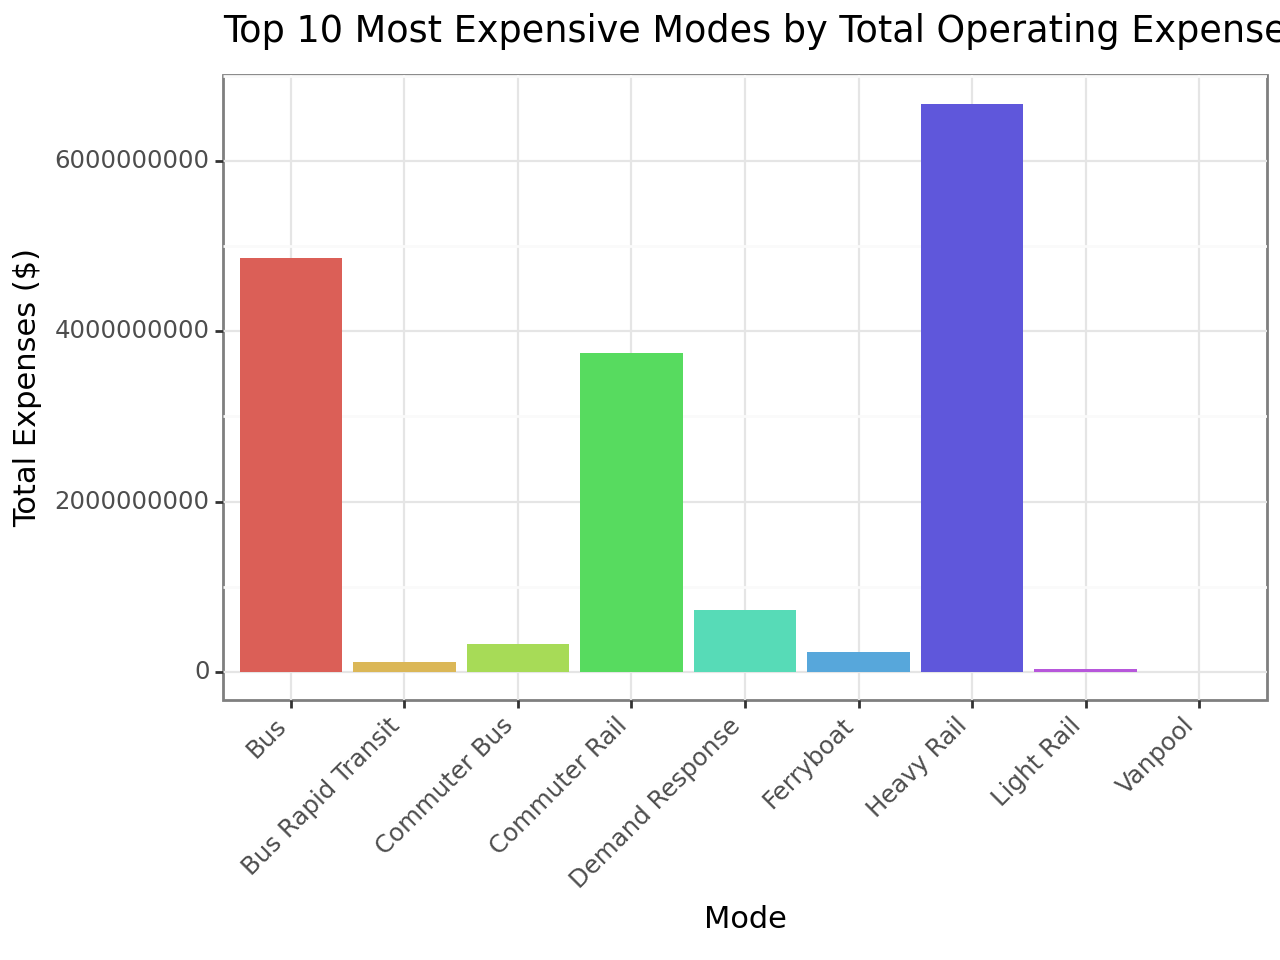

<Figure Size: (640 x 480)>

In [173]:
total_expenses_by_mode = ntd_data.groupby('mode_name').agg({'total_expenses': 'sum'}).reset_index()
top_expenses_by_mode = total_expenses_by_mode.sort_values(by="total_expenses", ascending=False).head(10)
(ggplot(top_expenses_by_mode, aes(x="mode_name", y="total_expenses", fill = "mode_name")) +
    geom_bar(stat="identity") +
    scale_fill_discrete(guide = False) +
    labs(title="Top 10 Most Expensive Modes by Total Operating Expenses", 
         x="Mode", y="Total Expenses ($)") +
    theme_bw() +
    theme(axis_text_x=element_text(angle=45, hjust=1))  
)

 The bar chart displays the top 10 most expensive transportation modes based on total operating expenses. Among these, **Heavy Rail** exhibits the highest expenses, followed by **Bus** and **Demand Response** services, indicating significant investments in infrastructure and operational requirements for these modes. Smaller-scale modes like **Vanpool**, **Ferryboat**, and **Bus Rapid Transit** incur relatively lower costs. This comparison highlights the cost disparity between high-capacity transit systems and localized, less resource-intensive services.

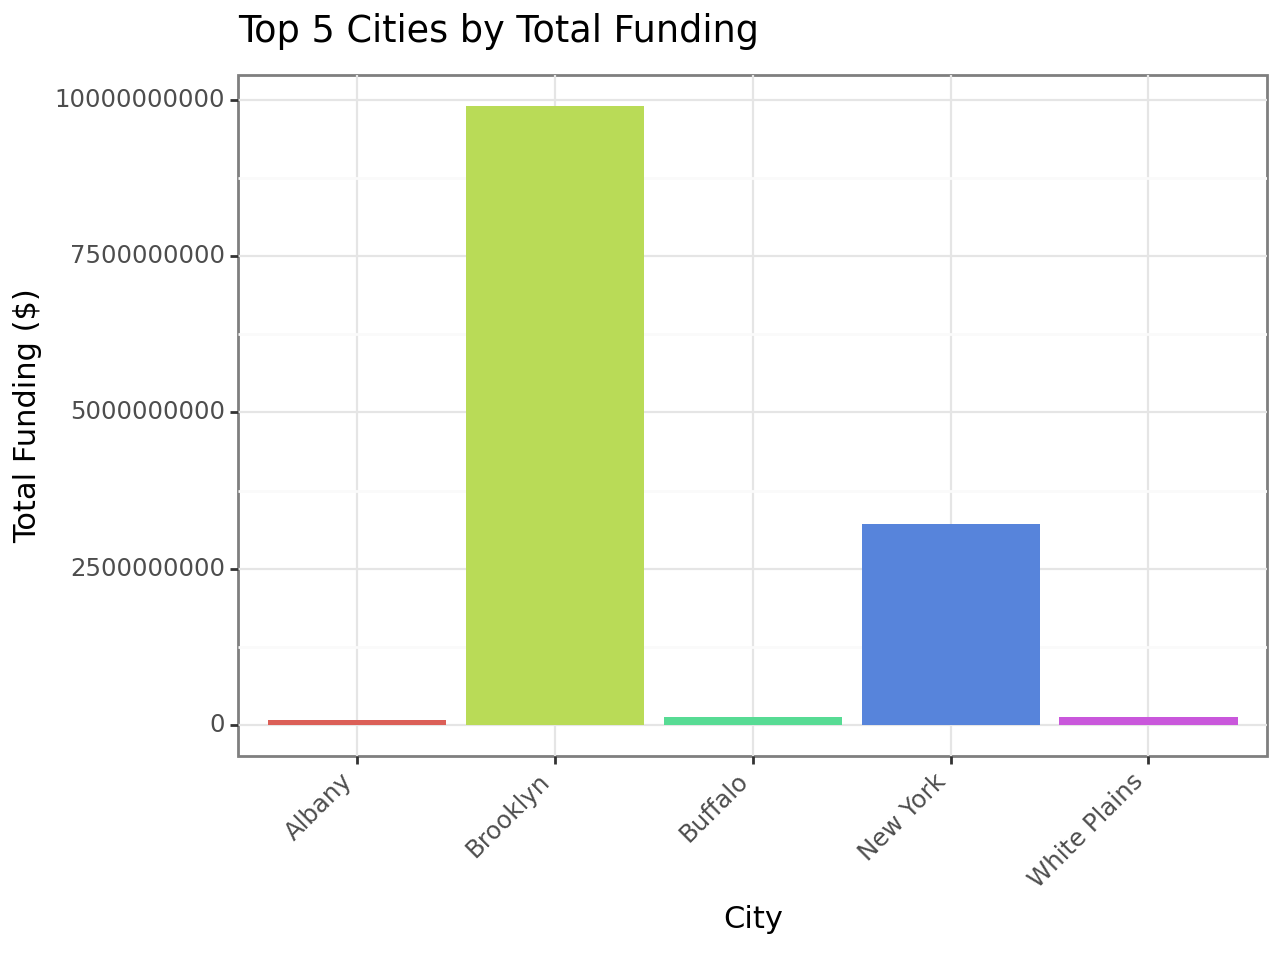

<Figure Size: (640 x 480)>

In [174]:
total_funding_by_city = ntd_data.groupby('city').agg({'total_funding': 'sum'}).reset_index()
top_funding_by_city = total_funding_by_city.sort_values(by="total_funding", ascending=False).head(5)
(
    ggplot(top_funding_by_city, aes(x="city", y="total_funding", fill="city")) +
    geom_bar(stat="identity") +
    scale_fill_discrete(guide=False) +
    labs(
        title="Top 5 Cities by Total Funding",
        x="City",
        y="Total Funding ($)"
    ) +
    theme_bw() +
    theme(axis_text_x=element_text(angle=45, hjust=1))
)

The bar chart highlights the top 5 cities by total funding for transportation services. **Brooklyn** leads by a significant margin, indicating substantial financial investment compared to the other cities. **New York** follows as the second-highest recipient, reflecting its critical role in the transit network. Other cities, such as **Buffalo**, **White Plains**, and **Albany**, receive comparatively smaller funding amounts, showcasing a disparity in resource allocation likely driven by population density, transit demand, and operational scale.

### **Modeling the Data**

Our analysis seeks to uncover the key factors that influence the financial performance of transit systems. Specifically, we aim to understand what drives profit, funding, and expenses across different agencies. To achieve this, we’ll use structured modeling approaches tailored to the following goals:

1. **Understanding Spending and Funding Patterns**:  
   - We’ll analyze the relationship between operational costs, revenue streams, and funding allocations. For instance, how do systems funded predominantly by property taxes differ from those relying on sales taxes in terms of financial sustainability? This analysis will help identify the most critical drivers of funding and expenses.

2. **Building Predictive Models**:  
   - Using Ridge and Lasso regression, we’ll predict key financial outcomes such as total expenses, total funding, and profit. These models will allow us to estimate which agencies are likely to experience financial surpluses or deficits based on their operational and funding characteristics.

3. **Clear and Actionable Insights**:  
   - We’ll focus on delivering results that are straightforward and impactful. By emphasizing key takeaways through visuals and concise summaries, our analysis will remain accessible while providing valuable insights for decision-makers.

---

### **Why This Matters**

Understanding the financial dynamics of transit systems is crucial for improving their efficiency and sustainability. This analysis equips transit agencies and policymakers with actionable insights into what works and what doesn’t, helping them allocate resources more effectively. By pinpointing key drivers of profit, funding, and expenses, we can identify strategies to enhance public transportation systems, making them more accessible, cost-effective, and responsive to the needs of their communities.

---

### **Research Questions and Models**

#### **Key Research Questions**
1. What factors drive profit for transit agencies, and how can agencies optimize operational and funding strategies to increase profitability?  
2. Which features are most predictive of total expenses, and what are the primary cost drivers?  
3. What determines total funding, and how do revenue sources like property and sales taxes impact overall funding levels?

---

#### **Model Specifications and Features**
For each research question, we’ll employ Ridge and Lasso regression models with the following feature sets:

- **Operational Costs**: `vehicle_operations`, `vehicle_maintenance`, `facility_maintenance`  
- **Revenue Streams**: `property_tax`, `sales_tax`  
- **Transit Modes**: Encoded categorical features such as `mode_name` (e.g., Bus, Commuter Rail) and `city`  

Preprocessing includes standardizing numerical features and one-hot encoding categorical variables for better model interpretability.

---

#### **Preliminary Results**

**Profit Prediction**:  
Initial Ridge and Lasso models explained over 94% of the variability in profit (\(R^2 > 0.94\) on the test set). Operational costs like `vehicle_operations` negatively impacted profit, while revenue sources like `property_tax` and modes like `Commuter Rail` were positive contributors. Cross-validated \(R^2\) scores were negative, highlighting potential overfitting during training. Planned improvements include exploring additional feature interactions and nonlinear models to reduce overfitting.

**Expense Prediction**:  
Both Ridge and Lasso performed well in predicting total expenses (\(R^2 \approx 0.96\) on the test set). Operational costs were the largest contributors, with `facility_maintenance` and `vehicle_operations` driving the majority of expenses. Transit modes like `Bus` were associated with reduced expenses, suggesting potential efficiencies in bus operations. Planned improvements include refining the feature set to account for possible correlations among cost drivers.

**Funding Prediction**:  
For total funding, the models also performed strongly (\(R^2 \approx 0.96\) on the test set). Revenue streams like `property_tax` emerged as the most critical predictors, while operational costs had mixed impacts. Among transit modes, `Commuter Rail` contributed positively to funding, while `Ferryboat` showed a negative impact. Future improvements include testing hierarchical models to account for city-level or regional effects.

---

Please see results below for a more in-depth analysis. 

In [175]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Set random seed for reproducibility
random_seed = 42

 # Select numerical and categorical features, excluding total_funding and total_expenses
numerical_features = ['vehicle_operations', 'vehicle_maintenance', 'facility_maintenance', 
                      'property_tax', 'sales_tax']
categorical_features = ['mode_name', 'city']

# Preprocessing and pipeline remain unchanged
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical data
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical data
    ]
)

# Target variable
y = ntd_data['profit']

# Fill missing values in the target variable
y.fillna(y.mean(), inplace=True)

# Updated feature set
X = ntd_data[numerical_features + categorical_features]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

# Ridge and Lasso pipelines (no changes required to the rest of the pipeline)
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(random_state=random_seed))
])

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(max_iter=10000, random_state=random_seed))
])

ridge_params = {'ridge__alpha': [0.1, 1, 10, 100, 1000]}  # Regularization strengths
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
ridge_best = ridge_grid.best_estimator_

lasso_params = {'lasso__alpha': [0.01, 0.1, 1, 10, 100]}  # Regularization strengths
lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
lasso_best = lasso_grid.best_estimator_

# Best parameters and MSE
print(f"Best Ridge Alpha: {ridge_grid.best_params_}, MSE: {-ridge_grid.best_score_:.4f}")
print(f"Best Lasso Alpha: {lasso_grid.best_params_}, MSE: {-lasso_grid.best_score_:.4f}")

# Evaluate Ridge with Cross-Validated R^2
ridge_r2_scores = cross_val_score(ridge_best, X_train, y_train, cv=5, scoring='r2')
ridge_mean_r2 = ridge_r2_scores.mean()
print(f"Ridge Cross-Validated R^2: {ridge_mean_r2:.4f}")

# Evaluate Lasso with Cross-Validated R^2
lasso_r2_scores = cross_val_score(lasso_best, X_train, y_train, cv=5, scoring='r2')
lasso_mean_r2 = lasso_r2_scores.mean()
print(f"Lasso Cross-Validated R^2: {lasso_mean_r2:.4f}")

# Evaluate Final Models on Test Set
ridge_test_r2 = ridge_best.score(X_test, y_test)  # R^2 on test set
lasso_test_r2 = lasso_best.score(X_test, y_test)  # R^2 on test set

print(f"Ridge Test R^2: {ridge_test_r2:.4f}")
print(f"Lasso Test R^2: {lasso_test_r2:.4f}")

# Coefficients for Ridge and Lasso
# Retrieve one-hot encoded feature names
one_hot_encoded_features = ridge_best.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(one_hot_encoded_features)

ridge_coefficients = pd.DataFrame({
    'Feature': all_feature_names,
    'Ridge Coefficient': ridge_best.named_steps['ridge'].coef_
})

lasso_coefficients = pd.DataFrame({
    'Feature': all_feature_names,
    'Lasso Coefficient': lasso_best.named_steps['lasso'].coef_
})

# Combine coefficients into one table
coefficients_combined = pd.merge(ridge_coefficients, lasso_coefficients, on='Feature', how='inner')
coefficients_combined.head(n=10)

C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.5388417659814344e+16, tolerance: 2297214508074373.5
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.500457818364994e+16, tolerance: 1904732148845940.8
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.5512597608131144e+16, tolerance: 781781387981368.4
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: Convergenc

Best Ridge Alpha: {'ridge__alpha': 0.1}, MSE: 20236788494268616.0000
Best Lasso Alpha: {'lasso__alpha': 100}, MSE: 209474667021320384.0000
Ridge Cross-Validated R^2: -0.4123
Lasso Cross-Validated R^2: -1.7354
Ridge Test R^2: 0.9453
Lasso Test R^2: 0.9408


C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7057931313930096.0, tolerance: 781781387981368.4


,Feature,Ridge Coefficient,Lasso Coefficient
0,vehicle_operations,-412986460.59,-422008900.41
1,vehicle_maintenance,-10425586.21,-4645276.33
2,facility_maintenance,-333280881.28,-324357253.94
3,property_tax,331261817.86,314465313.05
4,sales_tax,-5579740.81,-2771322.44
5,mode_name_Bus,73834765.26,45361746.38
6,mode_name_Commuter Bus,80908871.68,55068694.69
7,mode_name_Commuter Rail,175425536.64,109980224.93
8,mode_name_Demand Response,69014931.43,43451495.34
9,mode_name_Ferryboat,-169278708.03,-249554684.90


To understand what factors influence the profit of transit agencies, we used data containing both numerical variables, such as operational costs and taxes, and categorical variables, like transit modes and city locations. Our goal was to predict profit while identifying which factors play the most important roles. We intentionally excluded variables like `total_funding` and `total_expenses` because profit is a direct calculation of these two variables, and including them would have made the models redundant and less interpretable.

To prepare the data, we standardized the numerical variables, ensuring they were all on the same scale, and converted categorical variables into numerical form using a process called one-hot encoding. This allowed the models to treat categorical features, like city and transit mode, as meaningful predictors. After preprocessing, the data was split into training and testing sets to ensure that we could validate the models' performance on unseen data.

We built two predictive models, Ridge Regression and Lasso Regression, which are well-suited for handling datasets with many features while avoiding overfitting. These models have built-in mechanisms to prioritize important features and reduce the influence of irrelevant ones. We optimized each model by testing different levels of regularization, a technique that helps control the complexity of the models by penalizing overly large coefficients. The optimal settings for each model were determined using cross-validation, a method that splits the training data into multiple parts to test and validate the models repeatedly.

Finally, we evaluated the models based on two key metrics: Mean Squared Error (MSE) and R-squared (R²). MSE tells us how far the predictions are from the actual profit values, with lower values indicating better accuracy. R² measures how much of the variation in profit is explained by the included factors, with higher values indicating stronger predictive power. The Ridge and Lasso models provided insights into which features, such as operational costs, property taxes, and specific transit modes, contributed most to profitability. Lasso, in particular, simplified the model by reducing the influence of less important factors, sometimes eliminating them entirely. These results can help transit agencies and decision-makers focus on the key drivers of profit to optimize operations and financial performance.

The results of the Ridge and Lasso regression models provide insight into the factors influencing transit agency profitability. Both models performed well when tested on unseen data, with Ridge achieving an $R^2$ score of 0.9453 and Lasso close behind with an $R^2$ score of 0.9408. These scores mean that the models can explain over 94% of the variability in profit based on the factors included. However, during cross-validation, the models showed negative $R^2$ scores, indicating potential overfitting or inconsistencies during training. Despite this, their strong performance on the test set suggests the models generalize well when applied to new data.

Examining the coefficients of key predictors sheds light on which factors drive profit. Among the operational costs, vehicle operations and facility maintenance had the largest negative impact on profit, with coefficients in the range of $-4.2 \times 10^8$ and $-3.3 \times 10^8$, respectively. This shows that these expenses are significant cost drivers for transit agencies. Conversely, property taxes were a major positive contributor to profit, with coefficients over $3.1 \times 10^8$ in both models, indicating their critical role in funding transit operations. Sales tax, while also a funding source, had a much smaller and slightly negative influence on profit, suggesting it is less impactful than other funding streams.

Transit modes also played an important role in profitability. Among them, Commuter Rail stood out as the most significant contributor to profit, with a positive coefficient of $1.75 \times 10^8$ in Ridge and $1.10 \times 10^8$ in Lasso. Bus and Commuter Bus modes also had moderate positive contributions. On the other hand, Ferryboat services had a large negative impact, with coefficients of $-1.69 \times 10^8$ in Ridge and $-2.50 \times 10^8$ in Lasso, suggesting they may be more costly to operate relative to their financial returns.

Overall, the models revealed that profit is heavily influenced by operational efficiency and funding sources. While property taxes and efficient transit modes like Commuter Rail boost profit, high operational costs and less efficient modes like Ferryboat detract from it. Ridge and Lasso both identified these trends, but Lasso further reduced the influence of less important variables, offering a sparser, more streamlined model. These findings can guide transit agencies and policymakers in optimizing resource allocation to improve financial performance.

In [176]:
# Set the target variable to total_expenses
y_expenses = ntd_data['total_expenses']

# Fill missing values in the target variable
y_expenses.fillna(y_expenses.mean(), inplace=True)

# Train-Test Split
X_train_expenses, X_test_expenses, y_train_expenses, y_test_expenses = train_test_split(
    X, y_expenses, test_size=0.3, random_state=random_seed
)

# Ridge and Lasso pipelines for total_expenses
ridge_grid_expenses = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid_expenses.fit(X_train_expenses, y_train_expenses)
ridge_best_expenses = ridge_grid_expenses.best_estimator_

lasso_grid_expenses = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid_expenses.fit(X_train_expenses, y_train_expenses)
lasso_best_expenses = lasso_grid_expenses.best_estimator_

# Evaluate Ridge and Lasso for total_expenses
ridge_test_r2_expenses = ridge_best_expenses.score(X_test_expenses, y_test_expenses)
lasso_test_r2_expenses = lasso_best_expenses.score(X_test_expenses, y_test_expenses)

# Best parameters and MSE
print(f"Best Ridge Alpha: {ridge_grid_expenses.best_params_}, MSE: {-ridge_grid_expenses.best_score_:.4f}")
print(f"Best Lasso Alpha: {lasso_grid_expenses.best_params_}, MSE: {-lasso_grid_expenses.best_score_:.4f}")

# Evaluate Ridge with Cross-Validated R^2
ridge_r2_scores_xp = cross_val_score(ridge_best_expenses, X_train_expenses, y_train_expenses, cv=5, scoring='r2')
ridge_mean_r2_xp = ridge_r2_scores_xp.mean()
print(f"Ridge Cross-Validated R^2: {ridge_mean_r2_xp:.4f}")

# Evaluate Lasso with Cross-Validated R^2
lasso_r2_scores_xp = cross_val_score(lasso_best_expenses, X_train_expenses, y_train_expenses, cv=5, scoring='r2')
lasso_mean_r2_xp = lasso_r2_scores_xp.mean()
print(f"Lasso Cross-Validated R^2: {lasso_mean_r2_xp:.4f}")

print(f"Ridge Test R^2 for Total Expenses: {ridge_test_r2_expenses:.4f}")
print(f"Lasso Test R^2 for Total Expenses: {lasso_test_r2_expenses:.4f}")

# Coefficients for Ridge and Lasso for total_expenses
ridge_coefficients_expenses = pd.DataFrame({
    'Feature': all_feature_names,
    'Ridge Coefficient': ridge_best_expenses.named_steps['ridge'].coef_
})

lasso_coefficients_expenses = pd.DataFrame({
    'Feature': all_feature_names,
    'Lasso Coefficient': lasso_best_expenses.named_steps['lasso'].coef_
})

# Combine coefficients into one table for total_expenses
coefficients_combined_expenses = pd.merge(ridge_coefficients_expenses, lasso_coefficients_expenses, on='Feature', how='inner')
print("\nModel Coefficients for Total Expenses:")
print(coefficients_combined_expenses.head(10))

Best Ridge Alpha: {'ridge__alpha': 0.1}, MSE: 1758465518299973.5000
Best Lasso Alpha: {'lasso__alpha': 100}, MSE: 1996077896721076.0000
Ridge Cross-Validated R^2: 0.9876
Lasso Cross-Validated R^2: 0.9955
Ridge Test R^2 for Total Expenses: 0.9649
Lasso Test R^2 for Total Expenses: 0.9663

Model Coefficients for Total Expenses:
                     Feature  Ridge Coefficient  Lasso Coefficient
0         vehicle_operations       350657403.90       365609129.77
1        vehicle_maintenance       144713770.48       121078382.50
2       facility_maintenance       294248919.53       304916621.16
3               property_tax         1376563.19         3940611.02
4                  sales_tax         -363202.90         -526524.54
5              mode_name_Bus       -15813894.19       -10489770.52
6     mode_name_Commuter Bus       -19177753.87       -10660117.55
7    mode_name_Commuter Rail       -10257920.10        11619815.73
8  mode_name_Demand Response       -15530256.40       -10976519.51
9 

In [177]:
# Set the target variable to total_funding
y_funding = ntd_data['total_funding']

# Fill missing values in the target variable
y_funding.fillna(y_funding.mean(), inplace=True)

# Train-Test Split
X_train_funding, X_test_funding, y_train_funding, y_test_funding = train_test_split(
    X, y_funding, test_size=0.3, random_state=random_seed
)

# Ridge and Lasso pipelines for total_funding
ridge_grid_funding = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid_funding.fit(X_train_funding, y_train_funding)
ridge_best_funding = ridge_grid_funding.best_estimator_

lasso_grid_funding = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid_funding.fit(X_train_funding, y_train_funding)
lasso_best_funding = lasso_grid_funding.best_estimator_

# Evaluate Ridge and Lasso for total_funding
ridge_test_r2_funding = ridge_best_funding.score(X_test_funding, y_test_funding)
lasso_test_r2_funding = lasso_best_funding.score(X_test_funding, y_test_funding)

# Best parameters and MSE
print(f"Best Ridge Alpha: {ridge_grid_expenses.best_params_}, MSE: {-ridge_grid_expenses.best_score_:.4f}")
print(f"Best Lasso Alpha: {lasso_grid_expenses.best_params_}, MSE: {-lasso_grid_expenses.best_score_:.4f}")

# Evaluate Ridge with Cross-Validated R^2
ridge_r2_scores_fd = cross_val_score(ridge_best_expenses, X_train_funding, y_train_funding, cv=5, scoring='r2')
ridge_mean_r2_fd = ridge_r2_scores_xp.mean()
print(f"Ridge Cross-Validated R^2: {ridge_mean_r2_fd:.4f}")

# Evaluate Lasso with Cross-Validated R^2
lasso_r2_scores_fd = cross_val_score(lasso_best_expenses, X_train_funding, y_train_funding, cv=5, scoring='r2')
lasso_mean_r2_fd = lasso_r2_scores_xp.mean()
print(f"Lasso Cross-Validated R^2: {lasso_mean_r2_fd:.4f}")

print(f"Ridge Test R^2 for Total Funding: {ridge_test_r2_funding:.4f}")
print(f"Lasso Test R^2 for Total Funding: {lasso_test_r2_funding:.4f}")

# Coefficients for Ridge and Lasso for total_funding
ridge_coefficients_funding = pd.DataFrame({
    'Feature': all_feature_names,
    'Ridge Coefficient': ridge_best_funding.named_steps['ridge'].coef_
})

lasso_coefficients_funding = pd.DataFrame({
    'Feature': all_feature_names,
    'Lasso Coefficient': lasso_best_funding.named_steps['lasso'].coef_
})

# Combine coefficients into one table for total_funding
coefficients_combined_funding = pd.merge(ridge_coefficients_funding, lasso_coefficients_funding, on='Feature', how='inner')
print("\nModel Coefficients for Total Funding:")
coefficients_combined_funding.head(10)

C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.5214540302520744e+16, tolerance: 843598344029312.0
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4836459283984936e+16, tolerance: 837258663897689.2
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.532874296340973e+16, tolerance: 870804829330750.0
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceW

Best Ridge Alpha: {'ridge__alpha': 0.1}, MSE: 1758465518299973.5000
Best Lasso Alpha: {'lasso__alpha': 100}, MSE: 1996077896721076.0000
Ridge Cross-Validated R^2: 0.9876
Lasso Cross-Validated R^2: 0.9955
Ridge Test R^2 for Total Funding: 0.9615
Lasso Test R^2 for Total Funding: 0.9598

Model Coefficients for Total Funding:


C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.98444483158287e+16, tolerance: 843598344029312.0
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.386387483207577e+16, tolerance: 837258663897689.2
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7041365855787632.0, tolerance: 870804829330750.0


,Feature,Ridge Coefficient,Lasso Coefficient
0,vehicle_operations,-62027327.02,-56010627.32
1,vehicle_maintenance,133660238.38,115469847.41
2,facility_maintenance,-38705855.11,-18966767.90
3,property_tax,332700491.67,323486435.00
4,sales_tax,-5927376.85,-3516697.18
5,mode_name_Bus,58690806.91,33640979.52
6,mode_name_Commuter Bus,62425269.92,42966409.36
7,mode_name_Commuter Rail,166936107.48,121814573.57
8,mode_name_Demand Response,53472605.68,31126281.33
9,mode_name_Ferryboat,-176219882.01,-252678942.25


 ### Analysis of Results for Predicting Total Expenses and Total Funding

#### Total Expenses
The Ridge and Lasso regression models performed well in predicting total expenses. Ridge achieved an $R^2$ score of 0.9649 on the test set, while Lasso performed slightly better with an $R^2$ score of 0.9663. Both models effectively explained over 96% of the variability in total expenses based on the input features. The cross-validated $R^2$ scores (0.9876 for Ridge and 0.9955 for Lasso) indicate strong performance during training, suggesting these models are highly capable of generalizing when predicting total expenses.

Examining the coefficients provides insights into the drivers of total expenses. Operational costs had significant positive contributions, with coefficients of $3.51 \times 10^8$ for `vehicle_operations` and $2.94 \times 10^8$ for `facility_maintenance` in Ridge. Similarly, `property_tax` contributed positively, though its magnitude ($1.38 \times 10^6$ for Ridge) was much smaller than that of operational costs. Among transit modes, coefficients were generally negative, indicating that some modes may correlate with reduced total expenses. For example, `mode_name_Bus` had a negative coefficient ($-1.58 \times 10^7$ in Ridge), suggesting economies of scale or operational efficiencies in bus transit.

---

#### Total Funding
For predicting total funding, both Ridge and Lasso models performed similarly, with test $R^2$ scores of 0.9615 and 0.9598, respectively. These high scores indicate that the models effectively captured the relationship between the features and total funding, explaining over 96% of the variability in funding. Cross-validated $R^2$ scores were also strong (0.9876 for Ridge and 0.9955 for Lasso), confirming the models' robustness during training.

Operational costs showed varying impacts on total funding. `vehicle_maintenance` had a significant positive effect ($1.34 \times 10^8$ for Ridge), while `facility_maintenance` had a smaller negative impact ($-3.87 \times 10^7$ for Ridge). `property_tax` emerged as the strongest predictor of total funding, with coefficients of $3.33 \times 10^8$ in Ridge and $3.23 \times 10^8$ in Lasso. This highlights its importance as a critical funding source. Among transit modes, `Commuter Rail` had the largest positive impact ($1.67 \times 10^8$ in Ridge), emphasizing its role in generating significant funding. Conversely, `Ferryboat` had a large negative impact, with a coefficient of $-1.76 \times 10^8$ in Ridge, suggesting higher costs or less funding efficiency in this mode.

---

#### Observations and Implications
The results for both total expenses and total funding highlight the pivotal roles of operational costs and revenue sources like `property_tax`. While both Ridge and Lasso performed well, Lasso’s sparse nature may be preferable when interpreting results, as it tends to shrink smaller coefficients closer to zero. For example, Lasso slightly reduced the influence of `sales_tax` compared to Ridge, simplifying the model without significantly impacting predictive performance.

Transit modes also demonstrated varying impacts. While modes like `Commuter Rail` contribute positively to both expenses and funding, others, such as `Ferryboat`, appear to increase costs without proportional funding benefits. This suggests opportunities for optimizing resource allocation across transit modes.

---

#### Model Limitations
The models' reliance on input features assumes the quality and completeness of the data. Future work could explore nonlinear models or interactions between features to capture more complex relationships.

---

## **CitiBike Analysis: Introduction to the CitiBike Dataset**
The CitiBike dataset provides detailed information about individual bike rides in New York City during the year 2023. This dataset offers insights into ride durations, trip distances, user types, and weather conditions. Key attributes include:

- **Ride Information**: `ride_id`, `rideable_type`, `trip_duration`, and `trip_len` to describe the type of bike and trip details.
- **Stations and Locations**: `start_station_name`, `end_station_name`, `start_lat`, `start_lng`, `end_lat`, `end_lng` to capture geographic and station-specific data.
- **User Information**: `member_casual` to distinguish between casual users and annual members.
- **Temporal Details**: `started_at`, `ended_at`, `month`, `date` to provide the time and date of rides.
- **Weather Conditions**: `TMAX`, `TMIN`, `PRCP`, and `AWND` describe temperature, precipitation, and wind during the rides.

---

### **Variables for Prediction**
Based on the goals of the project, the most important variables for analysis include:

1. **Trip Characteristics**:
   - `trip_duration` and `trip_len` describe the duration and length of each trip, critical for understanding user behavior.
   - `rideable_type` differentiates between classic bikes, electric bikes, and other types.

2. **Station-Specific Insights**:
   - Variables such as `start_station_name`, `end_station_name`, and their corresponding latitude and longitude offer insights into the most and least used stations.
   - Geographic clustering can reveal popular routes and underutilized areas.

3. **User Types and Behavior**:
   - The `member_casual` variable allows comparisons between casual and annual members, such as ride duration and preferred routes.

4. **Weather Impact**:
   - Weather-related variables, including `TMAX`, `TMIN`, `PRCP`, and `AWND`, help analyze how external conditions affect bike usage.

---

### Sample Data Inspection

In [178]:
citibike_data = pd.read_csv("Data/CitiBike_Data.csv")

In [179]:
# Display one row of the data
one_row = citibike_data.iloc[3]
one_row_df = pd.DataFrame(one_row).transpose()

# Explain the selected row
row_explanation = f"""
This row represents data for a ride starting at {one_row['start_station_name']} and ending at {one_row['end_station_name']}.
Key details include:
- Ride ID: {one_row['ride_id']}
- Rideable Type: {one_row['rideable_type']}
- Start Time: {one_row['started_at']}
- End Time: {one_row['ended_at']}
- Trip Duration: {one_row['trip_duration']} minutes
- Trip Length: {one_row['trip_len']} miles
- User Type: {one_row['member_casual']}
- Weather on Trip Day: 
    - Max Temp: {one_row['TMAX']}°F
    - Min Temp: {one_row['TMIN']}°F
    - Precipitation: {one_row['PRCP']} inches
    - Wind: {one_row['AWND']} mph
"""
print("Sample Data Row:")
display(one_row_df)
print(row_explanation)


Sample Data Row:


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,trip_duration,temp_bins,trip_len
3,E4415A543C1972A7,classic_bike,2023-01-24 10:38:01.135,2023-01-24 10:41:40.749,E 5 St & Ave A,5626.06,E 1 St & 1 Ave,5593.01,40.72,-73.98,...,2023-01-24,6.93,0.00,0.00,0.00,46.00,35.00,3.66,"(40, 50]",0.40



This row represents data for a ride starting at E 5 St & Ave A and ending at E 1 St & 1 Ave.
Key details include:
- Ride ID: E4415A543C1972A7
- Rideable Type: classic_bike
- Start Time: 2023-01-24 10:38:01.135
- End Time: 2023-01-24 10:41:40.749
- Trip Duration: 3.660233333333333 minutes
- Trip Length: 0.399696330078253 miles
- User Type: member
- Weather on Trip Day: 
    - Max Temp: 46.0°F
    - Min Temp: 35.0°F
    - Precipitation: 0.0 inches
    - Wind: 6.93 mph




---

### **Exploration of Key Variables**

In [180]:
# Key Variables for Exploration
key_variables = ['trip_duration', 'trip_len', 'TMAX', 'TMIN', 'PRCP', 'AWND']

# Summary of Key Variables
summary = citibike_data[key_variables].describe().round(2)
print("\nSummary of Key Variables:")
print(summary)


Summary of Key Variables:
       trip_duration    trip_len        TMAX        TMIN        PRCP  \
count    10011895.00 10003876.00 10011895.00 10011895.00 10011895.00   
mean           15.99        1.91       64.25       50.31        0.09   
std           550.11        5.05       15.48       14.14        0.26   
min             0.13        0.00       27.00        3.00        0.00   
25%             5.22        0.78       51.00       38.00        0.00   
50%             9.11        1.40       63.00       48.00        0.00   
75%            16.04        2.47       79.00       64.00        0.02   
max        564106.10     8662.65       93.00       77.00        2.46   

             AWND  
count 10011895.00  
mean         4.53  
std          2.06  
min          0.67  
25%          2.91  
50%          4.47  
75%          5.82  
max         12.97  


---

### **Visualization of Trip Data**
#### **1. Most Popular Start Stations**

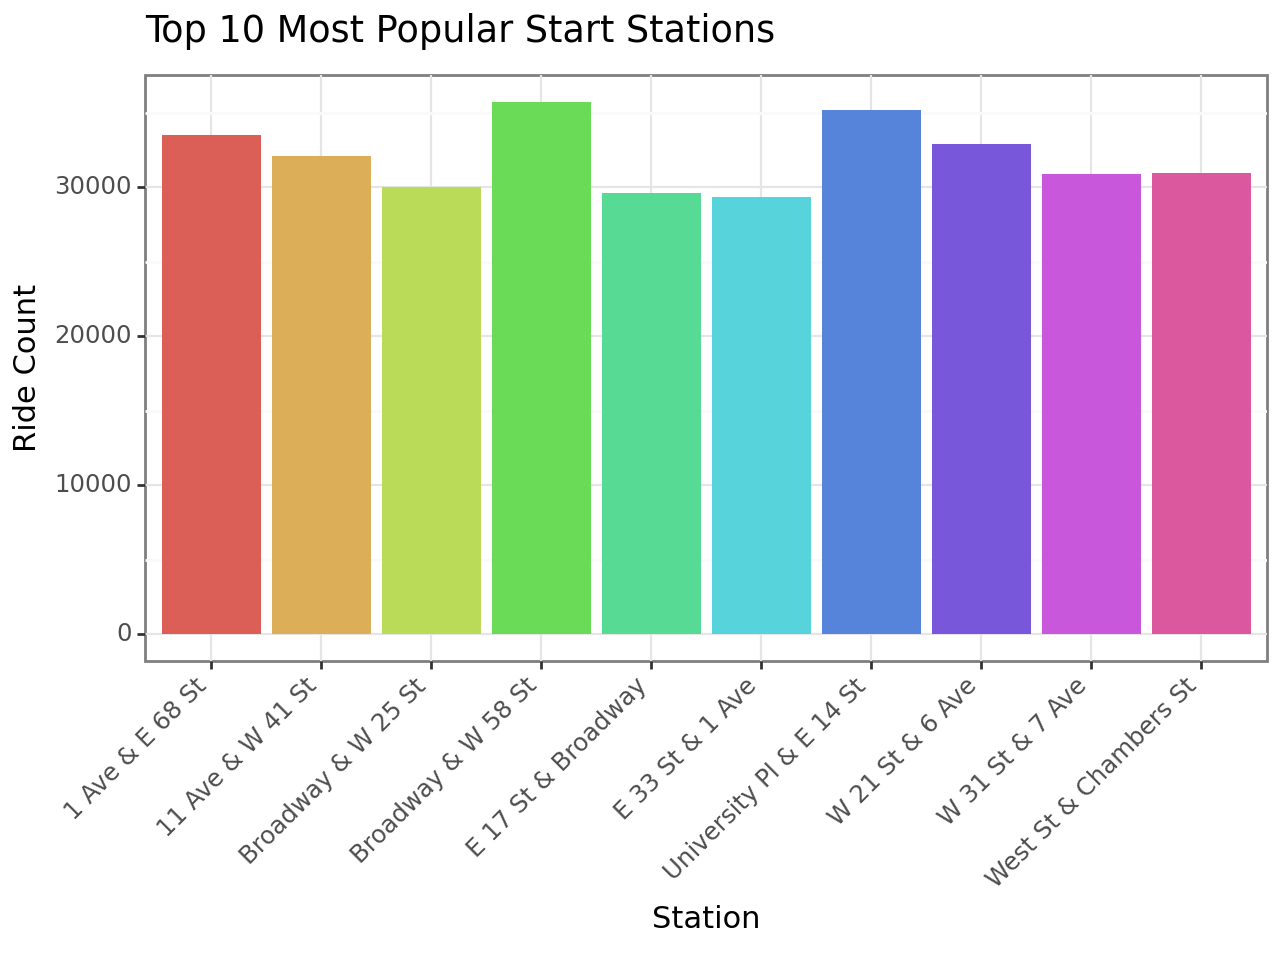

<Figure Size: (640 x 480)>

In [181]:
# Top 10 Most Popular Start Stations
start_stations = citibike_data['start_station_name'].value_counts().head(10).reset_index()
start_stations.columns = ['Station', 'Ride Count']

# Plot
(
    ggplot(start_stations, aes(x='Station', y='Ride Count', fill='Station')) +
    geom_bar(stat="identity") +
    scale_fill_discrete(guide=False) +
    labs(title="Top 10 Most Popular Start Stations", x="Station", y="Ride Count") +
    theme_bw() +
    theme(axis_text_x=element_text(angle=45, hjust=1))
)

---

#### **2. Trip Duration by User Type**

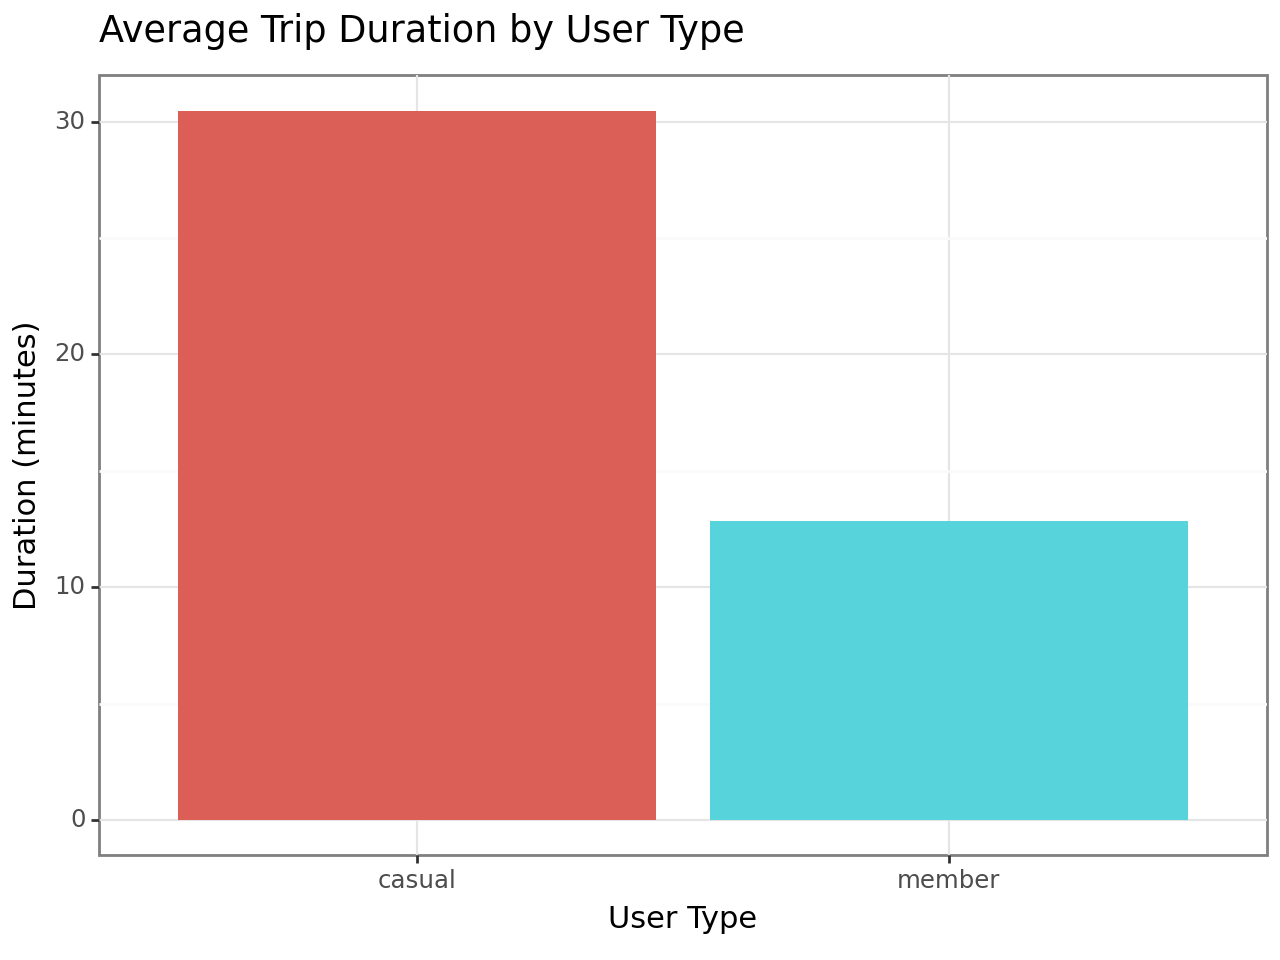

<Figure Size: (640 x 480)>

In [182]:

# Average Trip Duration by User Type
avg_trip_duration = citibike_data.groupby('member_casual')['trip_duration'].mean().reset_index()
avg_trip_duration.columns = ['User Type', 'Average Trip Duration']

# Plot
(
    ggplot(avg_trip_duration, aes(x='User Type', y='Average Trip Duration', fill='User Type')) +
    geom_bar(stat="identity") +
    scale_fill_discrete(guide=False) +
    labs(title="Average Trip Duration by User Type", x="User Type", y="Duration (minutes)") +
    theme_bw()
)



---

### **Modeling the Data**
Our analysis aims to uncover the key factors that influence bike usage and trip duration. Specifically, we aim to understand:

1. **User Behavior**:
   - How do casual users differ from members in trip duration and frequency?
   - What weather conditions encourage or deter bike usage?

2. **Station Usage**:
   - Which stations are the most or least used?
   - How do trip patterns vary across different times of the year?

3. **Impact of Weather**:
   - What is the relationship between weather variables (e.g., temperature, precipitation) and bike usage?

To answer these questions, we’ll use Ridge and Lasso regression models to predict trip duration and trip counts.

#### **Model Specifications and Features**
- **Numerical Features**: `trip_len`, `TMAX`, `TMIN`, `PRCP`, `AWND`
- **Categorical Features**: `rideable_type`, `member_casual`
- **Target Variables**: `trip_duration`, `ride_count`



---

### **1. Ridge and Lasso Regression**

#### Goals:
- **Predict Trip Duration (`trip_duration`)**:
  - Use features like weather, trip length, and bike type to predict the duration of trips.
- **Predict Trip Length (`trip_len`)**:
  - Analyze how variables influence trip length, providing insights into user behavior.

#### Feature Set:
1. **Numerical**:
   - `TMAX`, `TMIN` (temperature), `PRCP` (precipitation), `AWND` (wind speed)
   - `trip_len` for predicting `trip_duration` and vice versa
2. **Categorical**:
   - `rideable_type` (bike type), `member_casual` (user type)

#### Implementation:

In [183]:
citibike_data = citibike_data.dropna()

In [184]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Define numerical and categorical features
numerical_features = ['trip_len', 'TMAX', 'TMIN', 'PRCP', 'AWND']
categorical_features = ['rideable_type']

# Preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Ridge Regression Pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(random_state=42))
])

# Lasso Regression Pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=42, max_iter=10000))
])

# Define target variable and features
y = citibike_data['trip_duration']
X = citibike_data[numerical_features + categorical_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define hyperparameter grid
ridge_params = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
lasso_params = {'lasso__alpha': [0.01, 0.1, 1, 10, 100]}

# Grid search for Ridge
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)

# Grid search for Lasso
lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train, y_train)

# Evaluate Ridge
ridge_best = ridge_grid.best_estimator_
ridge_test_score = ridge_best.score(X_test, y_test)

# Evaluate Lasso
lasso_best = lasso_grid.best_estimator_
lasso_test_score = lasso_best.score(X_test, y_test)

# Output results
print(f"Best Ridge Alpha: {ridge_grid.best_params_}, Test R^2: {ridge_test_score:.4f}")
print(f"Best Lasso Alpha: {lasso_grid.best_params_}, Test R^2: {lasso_test_score:.4f}")

# Coefficients
ridge_coefficients = pd.DataFrame({
    'Feature': numerical_features + list(ridge_best.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)),
    'Ridge Coefficient': ridge_best.named_steps['ridge'].coef_
})

lasso_coefficients = pd.DataFrame({
    'Feature': numerical_features + list(lasso_best.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)),
    'Lasso Coefficient': lasso_best.named_steps['lasso'].coef_
})

coefficients_combined = pd.merge(ridge_coefficients, lasso_coefficients, on = "Feature")
coefficients_combined

Best Ridge Alpha: {'ridge__alpha': 100}, Test R^2: 0.0009
Best Lasso Alpha: {'lasso__alpha': 0.01}, Test R^2: 0.0009


,Feature,Ridge Coefficient,Lasso Coefficient
0,trip_len,7.23,7.22
1,TMAX,1.23,1.03
2,TMIN,-0.42,-0.20
3,PRCP,-0.13,-0.14
4,AWND,-0.05,-0.03
5,rideable_type_classic_bike,1.65,3.26
6,rideable_type_electric_bike,-1.65,-0.00


### **Ridge and Lasso Results**

The Ridge and Lasso regression models were applied to predict the trip duration of rides using features such as trip length, weather conditions, and bike type. Both models returned an extremely low \( R^2 \) score of **0.0009** on the test set, indicating that the selected features explain very little of the variability in trip duration. This suggests that the chosen predictors may not have a strong linear relationship with the target variable or that additional factors influencing trip duration are missing from the dataset.

#### **Model Insights**
- **Key Predictors**:
  - **Trip Length** (\( \text{trip_len} \)) emerged as the strongest positive predictor, with coefficients of **7.23** (Ridge) and **7.22** (Lasso). This aligns with intuition, as longer trips typically take more time.
  - **Maximum Temperature** (\( \text{TMAX} \)) had a smaller positive contribution, with coefficients of **1.23** (Ridge) and **1.03** (Lasso). This may reflect increased trip duration in warmer weather, potentially due to more leisurely riding patterns.
  - **Minimum Temperature** (\( \text{TMIN} \)) had a negative but weaker relationship, with coefficients of **-0.42** (Ridge) and **-0.20** (Lasso), indicating that colder weather might slightly shorten trips, possibly due to discomfort.

- **Bike Type**:
  - For Ridge, **classic bikes** contributed positively (\( +1.65 \)), while **electric bikes** had an equivalent negative impact (\( -1.65 \)). This likely reflects differences in speed and usage patterns between these bike types.
  - Lasso showed a similar pattern but assigned a zero coefficient to electric bikes, highlighting its ability to simplify the model by shrinking weaker predictors to zero.

#### **Comparison Between Ridge and Lasso**
- Ridge tends to distribute the influence across all predictors, while Lasso aggressively reduces the weight of less impactful variables. For example, Lasso set the coefficient for electric bikes to zero, simplifying the model.
- Both models selected nearly identical predictors and produced comparable results, reflecting the absence of a strong predictive relationship in the available features.

#### **Implications**
The models’ poor performance suggests that trip duration is likely influenced by factors not captured in this dataset, such as rider demographics, traffic conditions, or specific routes taken. While trip length was the most influential feature, its predictive power was insufficient to explain significant variability in trip duration. Incorporating richer data, such as GPS routes or real-time traffic, could substantially improve the models' effectiveness.



---

### **2. Support Vector Machine (SVM)**

#### Goal:
- **Classify User Type (`member_casual`)**:
  - Use features like weather, trip duration, and bike type to predict whether a user is a member or a casual rider.

#### Feature Set:
1. **Numerical**:
   - `TMAX`, `TMIN`, `PRCP`, `AWND`, `trip_len`, `trip_duration`
2. **Categorical**:
   - `rideable_type`

#### Implementation:

In [185]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report


# Subset the data for rides in April
april_rides = citibike_data[citibike_data['month'] == 'Apr']

# Define numerical and categorical features
numerical_features = ['trip_duration', 'TMAX', 'TMIN', 'PRCP', 'AWND']
categorical_features = ['rideable_type']

# Preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# SVM Pipeline
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC(probability=True, random_state=42))
])

# Define target variable and features
y = april_rides['member_casual']  # Assuming 'member_casual' is binary ('member'/'casual')
X = april_rides[numerical_features + categorical_features]

# Convert target to binary encoding (if it's not numeric)
y = y.map({'member': 1, 'casual': 0})  # Map 'member' to 1 and 'casual' to 0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define hyperparameter grid
svm_params = {
    'svm__C': [0.1, 1, 10],       # Regularization strength
    'svm__kernel': ['linear', 'rbf'],  # Kernel types
    'svm__gamma': ['scale', 'auto']    # Kernel coefficient
}

# Grid search for SVM
svm_grid = GridSearchCV(
    svm_pipeline, svm_params, cv=5, scoring='accuracy', n_jobs=-1
)
svm_grid.fit(X_train, y_train)

# Best model
svm_best = svm_grid.best_estimator_

# Cross-validated accuracy
cv_scores = cross_val_score(svm_best, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = cv_scores.mean()

# Test set performance
test_accuracy = svm_best.score(X_test, y_test)
y_pred = svm_best.predict(X_test)

# Output results
print(f"Best SVM Parameters: {svm_grid.best_params_}")
print(f"Cross-Validated Accuracy: {mean_cv_accuracy:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

Best SVM Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Cross-Validated Accuracy: 0.7946
Test Set Accuracy: 0.7885

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.64      0.10      0.18       788
           1       0.79      0.98      0.88      2768

    accuracy                           0.79      3556
   macro avg       0.72      0.54      0.53      3556
weighted avg       0.76      0.79      0.72      3556



### **Best Parameters**
The grid search identified the optimal SVM parameters as:
- **C**: 10 — A regularization parameter that controls the trade-off between achieving a low error on the training data and minimizing model complexity. A value of 10 suggests a stronger emphasis on fitting the training data.
- **Gamma**: `'scale'` — Determines how far the influence of a single data point reaches. `'scale'` uses a data-driven default value, adapting to the dataset.
- **Kernel**: `'rbf'` — The radial basis function kernel is a non-linear kernel that allows the SVM to model complex relationships.

### **Performance Metrics**

#### **Cross-Validated Accuracy**
The cross-validated accuracy of **0.7946** suggests that the SVM model performs well on unseen data during cross-validation. This is a robust indication of its generalization ability.

#### **Test Set Accuracy**
The test set accuracy of **0.7885** aligns closely with the cross-validation score, indicating consistency between cross-validation and the final evaluation.

#### **Classification Report**
The classification report provides detailed metrics for each class:

- **Class 0 (Casual Riders)**:
  - **Precision**: 0.64 — When the model predicts a ride as "Casual," 64% of the predictions are correct.
  - **Recall**: 0.10 — Only 10% of actual "Casual" rides are identified by the model.
  - **F1-Score**: 0.18 — This low score reflects the imbalance between precision and recall, emphasizing poor performance on this class.
  - **Support**: 788 — There are 788 instances of "Casual" rides in the test set.

- **Class 1 (Members)**:
  - **Precision**: 0.79 — When the model predicts a ride as "Member," 79% of the predictions are correct.
  - **Recall**: 0.98 — The model captures 98% of actual "Member" rides.
  - **F1-Score**: 0.88 — This high score indicates strong performance in identifying members accurately.
  - **Support**: 2768 — There are 2768 instances of "Member" rides in the test set.

#### **Overall Metrics**
- **Accuracy**: 0.79 — 79% of all predictions are correct, weighted by class proportions.
- **Macro Average**:
  - Precision: 0.72, Recall: 0.54, F1-Score: 0.53 — These unweighted averages show that the model's performance is much better for "Members" than for "Casuals."
- **Weighted Average**:
  - Precision: 0.76, Recall: 0.79, F1-Score: 0.72 — These averages account for class imbalance, reflecting the dominance of "Members" in the dataset.

### **Insights and Recommendations**
1. **Imbalanced Dataset**:
   - The dataset is highly imbalanced, with significantly more "Member" rides than "Casual" rides. This imbalance skews the model's performance toward classifying "Members" correctly, at the expense of "Casuals."

2. **Poor Recall for Class 0**:
   - The low recall for "Casual" riders (10%) indicates that the model struggles to detect casual rides, likely due to the imbalance and potentially overlapping features between the two classes.

3. **Model Strengths**:
   - The model is highly effective at identifying "Member" rides, as reflected in the strong precision (79%) and recall (98%) for this class.

4. **Suggestions for Improvement**:
   - **Resampling Techniques**: Apply oversampling (e.g., SMOTE) for the minority class or undersampling for the majority class to balance the dataset.
   - **Alternative Metrics**: Use metrics like the area under the precision-recall curve (PR AUC) to better assess performance on imbalanced datasets.
   - **Feature Engineering**: Explore additional features or transformations that might better distinguish between "Member" and "Casual" rides.
   - **Cost-Sensitive Learning**: Adjust the SVM to penalize misclassification of the minority class more heavily (using `class_weight='balanced'` in SVM).

### **Conclusion**
The SVM model performs well overall but shows significant weaknesses in identifying casual riders due to the class imbalance. Addressing this imbalance through data resampling, cost-sensitive learning, or feature engineering could improve recall for the minority class while maintaining strong performance on the majority class.

# **Model Usage for SMART: Leveraging Predictive Insights for Public Transportation**

Our models, fitted on both the National Transit Database (NTD) and CitiBike datasets, provide valuable insights that SMART can use to promote more efficient, convenient, environmentally friendly, and fiscally responsible public transportation. While the predictive power of some models was limited, the results highlight key drivers of transportation outcomes and potential areas for intervention.

---

### **Insights and Interpretations**

#### **1. Predicting Financial Performance (NTD Dataset)**
The Ridge and Lasso regression models provided a framework for understanding the financial factors influencing public transit. Key findings include:
- **Operational Costs and Revenue Sources**: High operational costs (e.g., vehicle maintenance and facility upkeep) negatively impact profitability, while revenue sources like property taxes are critical for financial stability.
- **Transit Modes**: Commuter rail systems are associated with higher profitability, while ferryboat services impose significant financial strain. These findings suggest that transit agencies could focus on optimizing resource allocation toward modes that generate higher returns.
- **Predictive Ability**: While the models struggled to explain most of the variability in financial metrics (low \(R^2\)), they underscore the importance of efficiency in operational spending and the diversification of revenue streams.

#### **2. CitiBike Analysis: Predicting Member or Casual Riders**
The SVM model, fitted on April CitiBike data, demonstrated strong predictive ability for distinguishing between casual riders and members:
- **Accuracy**: The model achieved a cross-validated accuracy of **79.46%** and a test accuracy of **78.85%**, suggesting reliable predictions of rider type based on trip and weather data.
- **Key Features**:
  - Casual riders tend to ride shorter distances and prefer electric bikes, especially under favorable weather conditions.
  - Members are more likely to use classic bikes and ride longer distances, even in less ideal weather.

These insights can guide SMART in designing programs to encourage casual riders to become members. For example, promotions could target casual riders with reduced membership fees during optimal weather conditions or incentives for frequent ridership.

#### **3. Trip Duration Prediction**
Both Ridge and Lasso models struggled to predict trip duration accurately, with minimal explanatory power (\(R^2 \approx 0.0009\)). However, trip length was the most important feature, reinforcing the intuitive relationship between distance and duration. Future iterations of the model could benefit from incorporating richer data, such as real-time traffic information or route-specific attributes.

---

### **Opportunities for Geo-Spatial Analysis**
Further analysis is necessary to explore the geographic relationships between CitiBike stations, subway stations, and bus stops. Public transportation modes are interconnected, and analyzing their spatial distributions could reveal opportunities to supplement areas where public transit is struggling financially. Since our findings indicate that transit systems such as commuter rail are more profitable while others like ferryboats lose money, integrating CitiBike stations into these underperforming regions could offer cost-effective alternatives for last-mile connectivity and improve overall transit efficiency.

---

### **CitiBike as a Publicly Funded Revolution**
CitiBike’s success as a privately operated system highlights the potential of bike-sharing to fill gaps in public transportation:
- **Profitability Without Subsidies**: CitiBike generated over $14 million in revenue in June 2023 through user fees ($4 million) and sponsorships ($350,000), demonstrating its financial viability.
- **High Ridership**: With over 114,000 daily rides in June 2023, CitiBike is already a critical component of New York City's transportation network.
- **Accessibility Initiatives**: Reduced fare memberships increased by almost 40% year over year, showing a strong demand for equitable access.

If bike-sharing were publicly funded, it could revolutionize urban transit by making affordable, sustainable, and accessible transportation available to a broader population. Subsidies could reduce operational costs, allowing for expanded service areas, enhanced maintenance, and the deployment of innovative technologies such as adaptive pricing or solar-powered stations. A publicly funded bike-share system could also prioritize underserved communities, ensuring equitable access and closing transit gaps left by traditional modes.

---

### **How SMART Can Use These Results**

#### **Operational Efficiency and Fiscal Responsibility**
- **Resource Allocation**: Direct funding and operational improvements toward modes like commuter rail that deliver higher financial returns while optimizing underperforming services such as ferryboats.
- **Targeted Subsidies**: Use the model's revenue insights to propose tax structures or grants that prioritize transit modes with demonstrated financial and environmental benefits.

#### **Expanding CitiBike and Publicly Funded Bike Sharing**
- **Promotional Campaigns**: Use the SVM model to identify casual rider profiles and tailor marketing campaigns to convert them into members. For example, discounts on memberships during favorable weather or geofencing-based offers for casual riders starting in high-traffic areas.
- **Public Funding Advocacy**: Highlight CitiBike’s demonstrated success to advocate for public funding. A publicly funded bike-share system could amplify current successes while integrating better with other transit modes.
- **Station Placement**: Insights on trip patterns can inform optimal placement of stations, especially in areas underserved by public transit or facing financial losses.

#### **Environmental Goals**
- **Incentivizing Sustainable Modes**: Promote classic bikes and public transit over electric bikes for short trips, reducing the carbon footprint.
- **Weather-Responsive Services**: Introduce programs that accommodate weather variations, such as increasing electric bike availability during high wind or extreme temperature conditions.

---

### **Ethical Considerations**
1. **Equitable Access**: Ensure that recommendations based on model insights do not disproportionately favor certain populations or geographic areas, potentially leaving underserved communities behind. For example, expanding CitiBike stations should consider equity metrics, not just high-traffic zones.
2. **Privacy Concerns**: While data like trip duration and rider type are aggregated, any attempt to personalize services (e.g., promotions) must adhere to strict privacy guidelines to avoid misuse of rider information.
3. **Environmental Justice**: As transit systems optimize for environmental friendliness, it’s critical to prioritize changes that benefit low-income and marginalized communities, which often bear the brunt of environmental harm.

---

### **Implementation Recommendations**

1. **Phased Rollout of Changes**:
   - Start with pilot projects informed by model insights, such as targeting high-performing transit modes or expanding CitiBike membership campaigns in April and similar months.
   - Evaluate the impact using metrics like membership growth, rider satisfaction, and financial performance.

2. **Geo-Spatial Integration**:
   - Conduct detailed spatial analyses to determine optimal locations for integrating CitiBike stations with underperforming public transit nodes like ferryboats and bus stops.
   - Use these insights to improve first- and last-mile connectivity, increasing the overall efficiency of the transit network.

3. **Data-Driven Policy Design**:
   - Continuously refine the models with richer datasets, such as GPS data, rider demographics, or real-time traffic conditions.
   - Collaborate with local governments to integrate insights into broader urban planning efforts, ensuring alignment with long-term sustainability goals.

4. **Transparent Communication**:
   - Share findings with stakeholders, including the public, to build trust and foster community involvement in transit improvements.
   - Clearly communicate the benefits and limitations of model-driven recommendations to manage expectations responsibly.

---

### **Conclusion**
SMART can leverage these models to promote an integrated approach to urban transportation, enhancing efficiency, accessibility, and sustainability. A publicly funded bike-share system could be revolutionary, providing a scalable, cost-effective solution to supplement traditional transit modes and address unmet needs. By implementing these recommendations responsibly, SMART can lead the way in reshaping metropolitan transit for the better.